In [37]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)
import pickle

In [38]:
# Save python objects to file
def save_obj_to_file(obj, name):
    with open(f"{name}.pickle", 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
# Loading python objects from file
def load_obj_from_file(name):
    with open(f'{name}.pickle', 'rb') as handle:
        return pickle.load(handle)

In [40]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [41]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents_arr = []
    for i in sents:
        array = i.split(':::')
        if len(array) != 2:
            continue
        sents_arr.append(array)
    return sents_arr

In [42]:
data = read_text("./project_resource/data/eng_yor.txt")
data = to_lines(data)
data = array(data)

In [43]:
# Remove punctuation
data[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in data[:,0]]
data[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in data[:,1]]

In [44]:
# convert to lowercase
for i in range(len(data)):
    data[i,0] = data[i,0].lower()
    
    data[i,1] = data[i,1].lower()

Text to Sequence Conversion
<br>
To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [45]:
# empty lists
eng_l = []
yor_l = []

# populate the lists with sentence lengths
for i in data[:,0]:
    eng_l.append(len(i.split()))

for i in data[:,1]:
    yor_l.append(len(i.split()))

In [46]:
length_df = pd.DataFrame({'eng':eng_l, 'yor':yor_l})

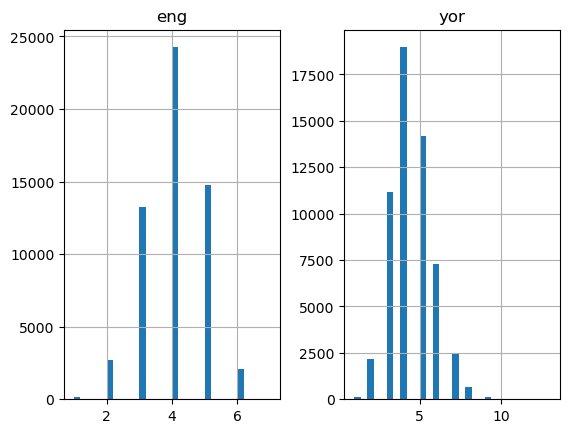

In [47]:
length_df.hist(bins = 30)
plt.show()

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [48]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [49]:
# prepare english tokenizer
eng_tokenizer = tokenization(data[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = max(eng_l)
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 8114


In [50]:
# prepare Yoruba tokenizer
yor_tokenizer = tokenization(data[:, 1])
yor_vocab_size = len(yor_tokenizer.word_index) + 1

yor_length = max(yor_l)
print('Yoruba Vocabulary Size: %d' % yor_vocab_size)

Yoruba Vocabulary Size: 6291


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above.

In [51]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

Model Building
<br><br>
We will now split the data into train and test set for model training and evaluation, respectively.

In [52]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.02, random_state = 2)

In [53]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_sequences(yor_tokenizer, yor_length, train[:, 1])

In [54]:
# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(yor_tokenizer, yor_length, test[:, 1])

Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.

In [55]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [56]:
model = build_model(eng_vocab_size, yor_vocab_size, eng_length, yor_length, 512)
rms = optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used 'sparse_categorical_crossentropy' as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

<br>
It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using ModelCheckpoint() to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [ ]:
filename = 'model.h1.8_mar_24'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=45, 
          validation_split = 0.1,
          callbacks=[checkpoint,early_stopping], verbose=1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [ ]:
# Savign the tokenizers to file;
save_obj_to_file(eng_tokenizer, "eng_tokenizer")
save_obj_to_file(yor_tokenizer, "yor_tokenizer")


Make Predictions
<br>
Let's load the saved model to make predictions.

In [ ]:
model = load_model('model.h1.8_mar_24')
preds = np.argmax(model.predict(testX.reshape((testX.shape[0],testX.shape[1]))),axis=-1)

In [ ]:
def get_word(n, tokenizer):
    return tokenizer.index_word.get(n)

In [ ]:
# convert predictions into text (Yoruba)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], yor_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], yor_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [ ]:
pd.set_option('display.max_colwidth', 200)

In [ ]:
pred_df.head(30)

<h1>User Testing </h1>

In [ ]:
array = [input("Enter text to translate: ")]
testSample = encode_sequences(eng_tokenizer, eng_length, np.array(array))
preds = np.argmax(model.predict(testSample.reshape((testSample.shape[0],testSample.shape[1]))),axis=-1)
# convert predictions into text (Yoruba)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], yor_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], yor_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))
print(f"Translation: {preds_text[0].strip()}")